In [1]:
import os
import neptune
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from scipy.stats import ttest_ind as ttest
import scipy

# from tensorflow.python import keras as keras
from keras.models import Model

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies
from src.results.dicarlo import get_dicarlo_su
from src.data_loader import Shifted_Data_Loader
from src.data_generator import ShiftedDataBatcher

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')
proj_root = '/home/elijahc/projects/vae'

In [3]:
def load_config(exps):
    props = load_properties(exps)
    params = load_params(exps)
    ids = [e.id for e in exps]
    for eid,pr,pa in zip(ids,props,params):
        out = {'id':eid}
        out.update(pr)
        out.update(pa)
        out['exp_dir']=os.path.join(proj_root,pr['dir'])
        yield out

In [4]:
conv_eids = [
    'DPX-29',
    'DPX-30',
]
dense_eids = [
    'DPX-10',
    'DPX-16',
#     'DPX-27',
]
# eids = conv_eids+dense_eids
conv_exps = neptune.project.get_experiments(id=conv_eids)
dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(conv_exps+dense_exps)
s_df = pd.DataFrame(list(load_config(exps)))
s_df.head()

,assembly_fn,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,exp_dir,generator_arch,id,im_translation,n_epochs,recon_weight,su_selectivity_fn,xent_weight,y_dim,z_dim
0,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-29,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-29,0.75,54000.0,0.0,NaN,15.0,35,35
1,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-30,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-30,0.75,54000.0,1.0,NaN,15.0,35,35
2,dataset.nc,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-10,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-10,0.75,54000.0,1.0,selectivity.pqt,15.0,35,35
3,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-16,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-16,0.75,54000.0,0.0,NaN,15.0,35,35


In [5]:
monkey_su = get_dicarlo_su(proj_root).dropna()
monkey_su = monkey_su.rename(columns={'category_name':'category'})
monkey_su.head()

,neuroid_id,region,subregion,layer,variation,tx,ty,rxy,object_name,category
3,pixel_10063,pixel,pixel,0,6,0.022860,0.039999,0.018588,0.040494,0.082507
4,pixel_10077,pixel,pixel,0,6,0.018335,0.044148,0.009387,0.044056,0.079289
5,pixel_10080,pixel,pixel,0,6,0.021876,0.048534,0.000640,0.056863,0.100170
6,pixel_10099,pixel,pixel,0,6,0.007417,0.068462,0.002355,0.086835,0.076571
7,pixel_10105,pixel,pixel,0,6,0.021272,0.077362,0.006853,0.111111,0.091232


In [6]:
conv_su = [pd.read_parquet(os.path.join(ed,'su_selectivity_1.pqt')) for ed in s_df[s_df.encoder_arch=='convnet'].exp_dir]
dense_su = [pd.read_parquet(os.path.join(ed,'su_selectivity_1.pqt')) for ed in s_df[s_df.encoder_arch=='dense'].exp_dir]

In [7]:
def get_pvals(models,shape=(2,2,3),mod_layers=['conv_4','y_enc']):
    pvals = np.zeros(shape=shape)
    print(pvals.shape)
    for i,csu in enumerate(models):
        j=0
        for reg,layer in zip(['V4','IT'],mod_layers):
            for k,metric in enumerate(['tx','ty','category']):
                a = monkey_su[monkey_su.region==reg][metric].values
                b = csu[csu.region==layer][metric].values
                t_stat,pval = ttest(a,b,equal_var=False,nan_policy='omit')
    #             print(i,j,k)
                pvals[i,j,k]=pval
            j+=1
    return pvals

In [8]:
conv_pvals = get_pvals(conv_su,mod_layers=['conv_4','y_enc'])
dense_pvals = get_pvals(dense_su,mod_layers=['dense_3','y_lat'])
pvals = np.concatenate([conv_pvals,dense_pvals],axis=0)

(2, 2, 3)
(2, 2, 3)


In [9]:
from scipy.stats import combine_pvalues as combine_pv
fishers_combined_prob = lambda pv: combine_pv(pv,method='fisher')

In [10]:
def combine_pvals(pvals,method='log_likelihood'):
    # We have pvals across:
    # 4 model architectures, comparing 2 brain areas (V4, IT), across 3 properties(tx,ty,cat)
    # The dims of pvals are structured [Arch,brain_area,property] or
    # Shape=[4,2,3]
    
    if method == 'log_likelihood':
        log_p = np.log(pvals)
        log_likelihood = log_p.sum(axis=-1).sum(axis=-1)
        return log_likelihood
    
    elif method == 'fishers':
        # fct wants a 1-D array of p-vals, so we reshape [4,2,3]->[4,6]
        pv = [np.squeeze(a) for a in np.vsplit(pvals.reshape(4,-1),4)]
        fct = [fishers_combined_prob(p) for p in pv]
        
        # fcteep only p-val and discard t-statistic
        fct = [p for _,p in fct]
        return fct
    else:
        raise ValueError('Acceptable values for method are log_likelihood or fishers')

In [16]:
s_df['log_likelihood'] = combine_pvals(pvals,method='log_likelihood')
s_df['FCT'] = combine_pvals(pvals,method='fishers')
s_df['logFCT'] = np.log(s_df.FCT)
models = [a+' : classify' for a in s_df.encoder_arch.values]
models = [m+'+recon' if r else m for m,r in zip(models,s_df.recon_weight.astype(np.bool))]
s_df['condition']=models
s_df[['id','encoder_arch','log_likelihood','logFCT','condition']].head()

,id,encoder_arch,log_likelihood,logFCT,condition
0,DPX-29,convnet,-233.230020,-210.735810,convnet : classify
1,DPX-30,convnet,-130.451670,-110.845378,convnet : classify+recon
2,DPX-10,dense,-419.834188,-394.410429,dense : classify+recon
3,DPX-16,dense,-290.044227,-266.464223,dense : classify


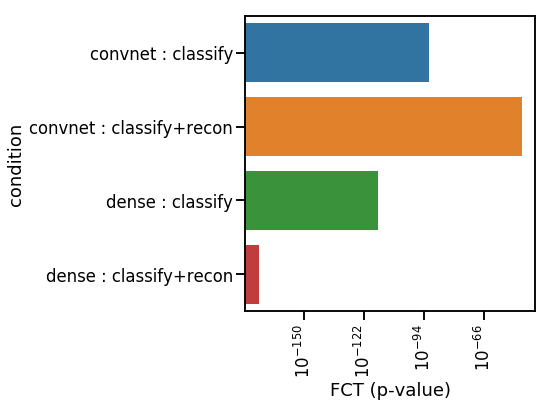

In [21]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,sharex=False,sharey=True,figsize=(8,6))
# for ax,col in zip(axs,['logFCT']):
order = [
    'convnet : classify',
    'convnet : classify+recon',
    'dense : classify',
    'dense : classify+recon',
]
sns.barplot(y='condition',x='FCT', data=s_df, ax=ax, order=order)
plt.xticks(rotation=90)
    
ax.set_xscale('log')
ax.set_xlabel('FCT (p-value)')
plt.tight_layout()
# ax.get_yaxis().set_visible(False)
# sns.despine(fig)


In [ ]:
# a = conv_su[1][conv_su[1].region=='y_enc'].category.values
a = conv_su[0][conv_su[0].region=='y_enc'].category.values

b = monkey_su[monkey_su.region=='V4'].category_name.values
ttest(a,b,equal_var=False)

In [ ]:
t_batches = DB.gen_test_batches(5,batch_size=512,bg='natural')
b = next(t_batches)

X,Xfg,y = b
w=1
noise_lvl = 0.8
fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),width=1.5,amount=noise_lvl)
noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]

xbg = DB.gen_backgrounds(X,noise_ims)
X_noised = np.clip(X+xbg,-1,1)

fig,axs = plt.subplots(1,4)

for ax,im in zip(axs,[X_noised,X,Xfg,xbg]):
    ax.imshow(im[6].reshape(56,56),cmap='gray')



In [ ]:
mod.metrics_names

In [ ]:
X,xfg,y = list(DB.gen_test_batches(1,batch_size=10000,bg='natural'))[0]
X.shape

In [ ]:
xbgs=[]
for noise_lvl in [0.1,0.9]:
        fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),mode='gaussian',mean=0,var=noise_lvl)
        noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        xbg = DB.gen_backgrounds(X,noise_ims)
        xbgs.append(xbg)
        
X_noised = np.clip(X+xbgs[0],-1,1)

In [ ]:
def model_gaussian_noise_sweep(mod,DB,var_levels,n_batches=20,**noise_kws):
    t_batches = list(DB.gen_test_batches(n_batches,batch_size=512,bg='natural'))
    x,_,_ = t_batches[0]
    xbgs = []
    for noise_lvl in var_levels:
        if noise_lvl == 0.0:
            fg_n = np.zeros(shape=(50,512,512,1))
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        else:
            noise_kws['var']=noise_lvl
            fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),**noise_kws)
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        
        xbg = DB.gen_backgrounds(x,noise_ims)
        xbgs.append(xbg)
        
        
    out_recs = []
    for lvl,xbg in zip(var_levels,xbgs):
        print('variance: ',lvl)
        for X,xfg,y in tqdm(t_batches):
            X_noised = np.clip(X+xbg,-1,1)
            Y = {'Generator':xfg,'Classifier':y}

            out = mod.test_on_batch(X_noised,Y)
            out = {k:v for k,v in zip(mod.metrics_names,out)}
            out['width']=w
            out['amount']=lvl
            out_recs.append(out)
            
    fig,axs = plt.subplots(1,len(var_levels))
    
    for ax,xbgs in zip(axs,xbgs):
        noise_ex = np.clip(x+xbgs,-1,1)
        ax.imshow(noise_ex[5].reshape(56,56),cmap='gray')
        
    return pd.DataFrame.from_records(out_recs)

In [ ]:
# gaussian_dfs = []
# variances = [0.0,0.5,1,1.5]
# for i, mod in enumerate(load_models(proj_root,exps)):
#     print(exps[i])
#     res_df = model_gaussian_noise_sweep(mod,DB,var_levels=variances,n_batches=20,mode='gaussian',mean=0.0)
#     gaussian_dfs.append(res_df)

In [ ]:
# for df,conf in zip(gaussian_dfs,confs):
#     df['Model ID']= conf['id']
#     df['encoder_arch']=conf['encoder_arch']
#     df['recon']=conf['recon_weight']
#     df['baseline_acc']=df[df.amount==0.0]['Classifier_acc'].values.mean()

In [ ]:
# gaussian_noise_df = pd.concat(gaussian_dfs)
# gaussian_noise_df['Relative Accuracy']=gaussian_noise_df['Classifier_acc']-gaussian_noise_df['baseline_acc']
# gaussian_noise_df.head()

In [ ]:
# sns.barplot(x='Model ID',y='Classifier_acc',data=gaussian_noise_df,hue='amount')

In [ ]:
import skimage as skim

In [ ]:
def plot_noise_sweep(X_noise,rand_idx=5):
    fig,axs = plt.subplots(1,len(X_noise),figsize=(3*len(X_noise),3))
    for ax,Xn in zip(axs,X_noise):
        ax.imshow(Xn[rand_idx].reshape(56,56),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
noise_sweeps = {
    'speckle':  {'mean':0, 'amount':np.array([0,0.1,0.3,0.6,0.9,1.5])**2},
    'gaussian': {'mean':0, 'amount':np.array([0,0.2,0.3,0.6,0.9,1.5])**2},
    's&p':  {'amount':np.array([0,0.05,0.1,0.2,0.3,0.9])}
}

In [ ]:
noise_sweeps['gaussian']['amount']

In [ ]:
def apply_noise(X, mode, amount, **noise_kws):
    X_out = []
    for amt in amount:
        if mode in ['speckle','gaussian']:
            kws = {'mean':0,'var':amt}
        elif mode in ['salt','pepper','s&p']:
            kws = {'amount':amt}
        
        if amt > 0.0:
            Xn = skim.util.random_noise(X,mode=mode,**kws)
            X_out.append(Xn)
        else:
            X_out.append(X)
        
    return X_out

In [ ]:
X_speckle = [X]
for amt in [0.1,0.3,0.6,0.9,1.5]:
    X_n = skim.util.random_noise(X,mode='speckle',mean=0,var=amt**2)
    X_speckle.append(X_n)

In [ ]:
plot_noise_sweep(X_speckle)

In [ ]:
X_gauss = apply_noise(X,mode='gaussian',amount=noise_sweeps['gaussian']['amount'])
plot_noise_sweep(X_gauss,rand_idx=25)

In [ ]:
amounts = noise_sweeps['s&p']['amount']
print(amounts)
X_sp = apply_noise(X,mode='s&p',amount=amounts)
plot_noise_sweep(X_sp,rand_idx=25)

In [ ]:
X_sp = [X]
for amt in [0.05,0.1,0.2,0.3,0.9]:
    X_n = skim.util.random_noise(X,mode='s&p',amount=amt)
    X_sp.append(X_n)

plot_noise_sweep(X_sp,rand_idx=20)

In [ ]:
def mod_noise_sweep(mod,Xn,batch_sz=512):
    mod_results = []
    Y = {'Generator':xfg,'Classifier':y}
    noise_recs = []
    for XN in Xn:
        out = mod.evaluate(XN,Y,batch_size=batch_sz)
        out = {k:v for k,v in zip(mod.metrics_names,out)}
        noise_recs.append(out)
        
    return pd.DataFrame.from_records(noise_recs)

# speckle_df = mod_noise_sweep(mod,X_speckle)

In [ ]:
# speckle_df['type']='speckle'
# speckle_df['amount']=[0,0.1,0.3,0.6,0.9,1.5]

In [ ]:
# speckle_dfs = []

In [ ]:
confs = list(load_config(exps))[2:]
for i,mod in enumerate(load_models(proj_root,exps[2:])):
    print(exps[2:][i])
    conf = confs[i]
    df = mod_noise_sweep(mod,X_speckle,batch_sz=512)
    df['type']='speckle'
    df['amount']=[0,0.1,0.3,0.6,0.9,1.5]
    for k,v in conf.items():
        df[k]=v
    speckle_dfs.append(df)

In [ ]:
speck_df = pd.concat(speckle_dfs)

In [ ]:
gaussian_dfs = []
confs = list(load_config(exps))
for i,mod in enumerate(load_models(proj_root,exps)):
    print(exps[i])
    conf = confs[i]
    df = mod_noise_sweep(mod,X_gauss,batch_sz=512)
    df['type']='gaussian'
    df['amount']=noise_sweeps['gaussian']['amount']
    for k,v in conf.items():
        df[k]=v
    gaussian_dfs.append(df)

In [ ]:
gauss_df = pd.concat(gaussian_dfs).reset_index().drop(columns=['index'])
gauss_df['amount']=np.round(gauss_df.amount.values,decimals=2)

In [ ]:
speck_df = speck_df.reset_index().drop(columns=['index'])

In [ ]:
# baseline = lambda x: x[x.amount == 0.0]['Classifier_acc'].values.mean()
# baseline = lambda x: x[x.amount==0]['Classifier_acc'].values.max()
baseline = lambda x: x.max()
# key = lambda x: print(x)

In [ ]:
speck_df['baseline_acc']=speck_df.groupby('id')['Classifier_acc'].transform(baseline)
speck_df['Accuracy Change']=speck_df['Classifier_acc']-speck_df.baseline

In [ ]:
gauss_df['baseline']=gauss_df.groupby('id')['Classifier_acc'].transform(baseline)
gauss_df['Accuracy Change']=gauss_df['Classifier_acc']-gauss_df.baseline

In [ ]:
sns.barplot(x='id',y='Classifier_acc',hue='amount',data=speck_df)

In [ ]:
speck_df.to_pickle('../data/speckle_noise_eval.pk')
gauss_df.to_pickle('../data/gauss_noise_eval.pk')

In [ ]:
sns.set_context('paper')
fig,axs = plt.subplots(1,1,figsize=(3,3))
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=speck_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Variance')
plt.ylim(0,-0.6)

In [ ]:
fig.savefig('../figures/sfn/speckle_noise.pdf',dpi=300)

In [ ]:
sns.set_context('paper')
fig,axs = plt.subplots(1,1,figsize=(3,3))
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=gauss_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Variance')
plt.ylim(0,-0.6)

In [ ]:
fig.savefig('../figures/sfn/gauss_noise.pdf',dpi=300)

In [ ]:
sns.set_context('paper')
g = sns.FacetGrid(col='id',data=gauss_df[gauss_df.amount>0],ylim=(0,0.8),height=2.5,hue='encoder_arch')
g.map(sns.barplot,'amount','Classifier_acc')
g.map(plt.xticks,rotation=90)
# g.map(plt.hlines(y=0.1,xmin=0,xmax=2.25,linestyles='dashed'))
# g.map()
# sns.barplot(x='id',y='Classifier_acc',hue='amount',data=gauss_df)

In [ ]:
g.fig.savefig('../figures/sfn/gauss_noise_bars.pdf',dpi=300)

In [ ]:
sns.set_context('paper')
g = sns.FacetGrid(col='id',data=speck_df[speck_df.amount>0],ylim=(0,0.8),height=2.5,hue='encoder_arch')
g.map(sns.barplot,'amount','Classifier_acc')
g.map(plt.xticks,rotation=90)

In [ ]:
g.fig.savefig('../figures/sfn/speckle_noise_bars.pdf',dpi=300)

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(row='id',data=speck_df,ylim=(0,0.8))
g.map(sns.barplot,'amount','Classifier_acc')
plt.xticks(rotation=90)

In [ ]:
sns.lineplot(x='amount',y='Accuracy Change',hue='encoder_arch',style='recon_weight',data=speck_df)
plt.ylim(0,-0.6)

In [ ]:
confs = list(load_config(exps))
conf = confs[1]

In [ ]:
conf.items()

In [ ]:
# from tqdm.autonotebook import tqdm
def model_noise_sweep(mod,DB,noise_levels,n_batches=20,**noise_kws):
    t_batches = list(DB.gen_test_batches(n_batches,batch_size=512,bg='natural'))
    x,_,_ = t_batches[0]
    xbgs = []
    for noise_lvl in noise_levels:
        if noise_lvl == 0.0:
            fg_n = np.zeros(shape=(50,512,512,1))
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        else:
            fg_n = DB.gen_bg_noise(im_stack=np.zeros(shape=(50,512,512,1)),**noise_kws)
            noise_ims = [fg_n[i].reshape(512,512,1) for i in np.arange(50)]
        xbg = DB.gen_backgrounds(x,noise_ims)
        xbgs.append(xbg)
        
    out_recs = []
    for lvl,xbg in zip(noise_levels,xbgs):
        print('noise: ',lvl)
        for X,xfg,y in tqdm(t_batches):
            X_noised = np.clip(X+xbg,-1,1)
            Y = {'Generator':xfg,'Classifier':y}

            out = mod.test_on_batch(X_noised,Y)
            out = {k:v for k,v in zip(mod.metrics_names,out)}
            out['width']=w
            out['amount']=lvl
            out_recs.append(out)
    return pd.DataFrame.from_records(out_recs)

In [ ]:
mod_res_dfs = []
for i, mod in enumerate(load_models(proj_root,exps)):
    print(exps[i])
    res_df = model_noise_sweep(mod,DB,noise_levels=[0.0,0.3,0.6,0.9],n_batches=20)
    mod_res_dfs.append(res_df)

In [ ]:
confs = list(load_config(exps))

In [ ]:
for df,conf in zip(mod_res_dfs,confs):
    df['Model ID']= conf['id']
    df['encoder_arch']=conf['encoder_arch']
    df['recon']=conf['recon_weight']
    df['baseline_acc']=df[df.amount==0.0]['Classifier_acc'].values.mean()

In [ ]:
noise_df = pd.concat(mod_res_dfs)
noise_df['Relative Accuracy']=noise_df['Classifier_acc']-noise_df['baseline_acc']
noise_df.head()

In [ ]:
sns.barplot(x='amount',y='Relative Accuracy',hue='encoder_arch',data=noise_df)

In [ ]:
g = sns.FacetGrid(data=noise_df,row='encoder_arch',col='recon',)
g = g.map(sns.lineplot,'amount','Relative Accuracy')

In [ ]:
g = sns.FacetGrid(data=noise_df,row='encoder_arch',col='recon',)
g = g.map(sns.lineplot,'amount','Classifier_acc')

In [ ]:
sns.set_context('talk')
sns.lineplot(x='amount',y='Relative Accuracy',data=noise_df,hue='encoder_arch',style='recon')
plt.ylim(0.0,-0.1)

In [ ]:
sns.set_context('talk')
sns.lineplot(x='amount',y='Classifier_acc',data=noise_df,hue='encoder_arch',style='recon')
# plt.ylim(0.0,-0.1)

In [ ]:
sns.barplot(x='Model ID',y='Relative Accuracy',data=noise_df,hue='amount')

In [ ]:
sns.barplot(x='amount',y='Classifier_acc',data=res_df)

In [ ]:
t_batches = list(DB.gen_test_batches(20,batch_size=512,bg='natural'))

for lvl,xbg in zip(noise_amt,xbgs):
    print('noise: ',lvl)
    for X,xfg,y in t_batches:
        X_noised = np.clip(X+xbg,-1,1)
        Y = {'Generator':xfg,'Classifier':y}
        
        out = mod.test_on_batch(X_noised,Y)
        out = {k:v for k,v in zip(mod.metrics_names,out)}
        out['width']=w
        out['amount']=lvl
        out_recs.append(out)
#         print(out)

In [ ]:
res_df = pd.DataFrame.from_records(out_recs)

In [ ]:
np.median(xbg)

In [ ]:
X_noised = np.clip(X+xbg,-1,1)
plt.imshow(X_noised[6].reshape(56,56),cmap='gray')